In [30]:
!pip install pygame
!pip install gymnasium

^C
ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user


In [31]:
!mkdir models2

mkdir: cannot create directory ‘models2’: File exists


In [32]:
from collections import namedtuple, deque
import random 
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time  # for sleep
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from collections import deque

class PredatorPreyEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'render-fps': 4}
    
    def __init__(self,
                render_mode=None,
                size:int=10,
                vision:int=5,
                predator:int =3,
                prey:int =1,
                error_reward:float=-2,
                success_reward:float=10,
                living_reward:float=-1,
                img_mode:bool=False,
                episode_length:int=100,
                history_length:int=4,
                communication_bits:int=0,
                cooperate:float=1):
        self.size  = size
        self.vision = vision
        self.window_size = 500
        self.render_mode = render_mode
        self.predator_num = predator
        self.prey_num = prey
        self.active_predator = [True for i in range(self.predator_num)]
        self.active_prey = [True for i in range(self.prey_num)]
        self.error_reward = error_reward
        self.success_reward = success_reward
        self.living_reward = living_reward
        self.episode_length = episode_length
        self.img_mode = img_mode
        self.steps = 0
        self.window = None
        self.clock = None
        self.cooperate = cooperate
        self.render_scale = 1
        self.observation_space = spaces.Dict({
            'predator': spaces.Sequence(spaces.Box(0, size-1, shape=(2,), dtype=np.int32)),
            'prey': spaces.Box(0, size-1, shape=(2,), dtype=np.int32),
        })
        total_actions = 5
        self.action_space_predator = spaces.MultiDiscrete([total_actions]*predator)
        self.action_space_prey = spaces.MultiDiscrete([total_actions]*prey)
        self.single_action_space = spaces.Discrete(total_actions)
        self._action_to_direction = {
            0: np.array([0, 1]),
            1: np.array([1, 0]),
            2: np.array([0, -1]),
            3: np.array([-1, 0]),
            4: np.array([0, 0])
        }
        self.frame_history = deque(maxlen=4)
        self.history_length = history_length
        self.communication_bits = communication_bits
        if self.communication_bits>0:
            self.pred_communication = np.zeros((self.predator_num))
            self.prey_communication = np.zeros((self.prey_num))

    def _get_obs(self):
        if self.img_mode:
            return self._get_np_arr_obs()
        return {
            'predator': self._predator_location,
            'prey': self._prey_location
        }
    
    def _get_np_arr_obs(self):
        predator_states = []
        prey_states = []
        for i in range(len(self._predator_location)):
            state = self._render_predator_frame(predator_id=i)
            predator_states.append(state)
        for i in range(len(self._prey_location)):
            state = self._render_prey_frame(prey_id=i)
            prey_states.append(state)
        return {
            "predator":predator_states, 
            "prey":prey_states
        }
    
    def _get_info(self):
        return {}
    
    def reset(self, *, seed: int=1, options=None):
        self._predator_location = np.random.randint(0, self.size, size=(self.predator_num, 2))
        self._prey_location = np.random.randint(0, self.size, size=(self.prey_num, 2))
        self.steps = 0
        self.active_pred = [True for i in range(self.predator_num)]
        self.active_prey = [True for i in range(self.prey_num)]
        if self.render_mode == 'human':
            self._render_frame()
        self._save_frame_history()
        return self._get_frame_history(self.history_length), self._get_info()
    
    def _get_reward(self):
        # if any predator reaches prey, success. else, living reward
        rewards = [self.living_reward for i in range(self.predator_num)]
        for i in range(self.predator_num):
            if self._predator_location[i] in self._prey_location:
                rewards = [self.cooperate*self.success_reward for i in range(self.predator_num)]
                rewards[i] = self.success_reward

        return rewards
    
    def _get_prey_reward(self):
        # if any predator reaches prey, success. else, living reward
        rewards = [self.success_reward for i in range(self.prey_num)]
        for i in range(self.prey_num):
            if self._prey_location[i] in self._predator_location:
                rewards[i] = 0
        return rewards
    
    def _is_done(self):
        # if all prey are gone or episode length is reached, done
        if self.steps >= self.episode_length:
            return True
        if np.sum(self.active_prey) == 0:
            return True
        return False

    def _is_valid_predator(self, location, index):
        # check if location is valid
        if location[0] < 0 or location[0] >= self.size or location[1] < 0 or location[1] >= self.size:
            return False
        if location in np.delete(self._predator_location, index, axis=0):
            return False
        return True
    
    def _is_valid_prey(self, location, index):
        # check if location is valid for prey of i'th index
        if location[0] < 0 or location[0] >= self.size or location[1] < 0 or location[1] >= self.size:
            return False
        if location in np.delete(self._prey_location, index, axis=0):
            return False
        return True
    
    def render(self):
        '''
        Render the environment.
        '''
        if self.render_mode =='rgb_array':
            return self._render_frame()

    def _save_frame_history(self):
        self.frame_history.append(self._get_obs())

    def _get_frame_history(self, history=4):
        if len(self.frame_history) < history:
            return None
        return list(self.frame_history)[-history:]

    def step(self, action_pred, action_prey, pred_communication=None, prey_communication=None):
        # action_pred is a list of actions for each predator
        # action_prey is a list of actions for each prey
        # action is a number from 0 to 3
        # 0: up, 1: right, 2: down, 3: left
        # if in the new locations after actions two predator overlap each other, the action will not take place
        # if in the new locations after actions a predator overlaps a prey, the prey will be eaten and predator will continue
        # if in the new locations after actions a predator overlaps a wall or is on the edge, the predator will not move
        # if in the new locations after actions a prey overlaps a wall or is on the edge, the prey will not move
        # if in the new locations after actions a prey overlaps a predator, the predator will eat the prey and predator will continue

        if self._is_done():
            raise RuntimeError("Episode is done")
        self.steps += 1
        # move predator
        for i in range(self.predator_num):
            if self.active_predator[i] == False:  # if predator is dead,
                continue
            if i < len(action_pred):
                action = action_pred[i]
            else:
                action = self.single_action_space.sample()
            new_location = self._predator_location[i] + self._action_to_direction[action]
            if self._is_valid_predator(new_location, i):
                self._predator_location[i] = new_location

        # move prey
        for i in range(self.prey_num):
            if self.active_prey[i] == False:  # if prey is dead,
                continue
            if i < len(action_prey):
                action = action_prey[i]
            else:
                action = self.single_action_space.sample()
            
            new_location = self._prey_location[i] + self._action_to_direction[action]
            if self._is_valid_prey(new_location, i):
                self._prey_location[i] = new_location

        # check if any predator reaches prey and give reward
        pred_reward = self._get_reward()
        prey_reward = self._get_prey_reward()
        for i in range(self.predator_num):
            for j in range (self.prey_num):
                if np.all(self._predator_location[i] == self._prey_location[j]):
#                     print("EATEN !!!")
                    self.active_prey[j] = False
        
        #save communication of agents
        if self.communication_bits > 0:
            self.pred_communication = pred_communication
            self.prey_communication = prey_communication

        done = self._is_done()
        reward = {
            'predator': pred_reward,
            'prey': prey_reward
        }
        if self.render_mode == 'human':
            self._render_frame()
        self._save_frame_history()
        return self._get_frame_history(self.history_length), reward, done, self._get_info()
        
    def _render_predator_frame(self, predator_id:int=0):
        # the predator with predator_id will be in the center of the frame and the frame will be of size vision x vision
        # the predator with predator_id will be green
        # if predator_id is None, the function ends
        # if the predator is on the edge of the frame, the cells outside the grid will be white
        # the predator is blue
        # the prey is red

        if predator_id==None:
            return
        frame = np.zeros((4, self.vision, self.vision), dtype=np.uint8)
        # draw predator
        pred_loc = self._predator_location[predator_id]
        min_pred_loc = pred_loc - np.array([self.vision//2, self.vision//2])
        max_pred_loc = pred_loc + np.array([self.vision//2, self.vision//2])

        # add predator to centre of frame
        frame[1, self.vision//2, self.vision//2] = self.render_scale 

        # for each predator or prey within min and max it will be added in the frame
        for i in range(self.predator_num):
            if i==predator_id:
                continue
            if (min_pred_loc[0] <= self._predator_location[i][0] <= max_pred_loc[0] 
            and 
            min_pred_loc[1] <= self._predator_location[i][1] <= max_pred_loc[1]):
                loc_x = self._predator_location[i][0]-min_pred_loc[0]
                loc_y = self._predator_location[i][1]-min_pred_loc[1]
                frame[2, loc_x, loc_y] = self.render_scale 
                # frame[2, loc_x, loc_y] = self.pred_communication[i]
                if self.communication_bits > 0:
                    frame[3, loc_x, loc_y] = self.pred_communication[i]
        
        
        for i in range(self.prey_num):
            if (min_pred_loc[0] <= self._prey_location[i][0] <= max_pred_loc[0] 
            and 
            min_pred_loc[1] <= self._prey_location[i][1] <= max_pred_loc[1]):
                
                frame[0, self._prey_location[i][0]-min_pred_loc[0], self._prey_location[i][1]-min_pred_loc[1]] = self.render_scale 
                
        # create white for cells outside grid
        if min_pred_loc[0] < 0:
            frame[:, :abs(min_pred_loc[0]), :] = self.render_scale 
        if max_pred_loc[0] >= self.size:
            frame[:, -(max_pred_loc[0]-self.size+1):, :] = self.render_scale 
        if min_pred_loc[1] < 0:
            frame[:, :, :abs(min_pred_loc[1])] = self.render_scale 
        if max_pred_loc[1] >= self.size:
            frame[:, :, -(max_pred_loc[1]-self.size+1):] = self.render_scale 
        
        return frame

    def _render_prey_frame(self, prey_id:int=1):
        # the prey will be in the centre of the frame and the frame will be of size vision x vision
        # the prey will be red
        # the prey with prey_id will be green
        # the predator is blue
        # if prey_id is None, the function ends
        # if the prey is on the edge of the frame, the cells outside the grid will be white

        if prey_id==None:
            return
        frame = np.zeros((3, self.vision, self.vision), dtype=np.uint8)
        # draw prey
        prey_loc = self._prey_location[prey_id]
        min_prey_loc = prey_loc - np.array([self.vision//2, self.vision//2])
        max_prey_loc = prey_loc + np.array([self.vision//2, self.vision//2])

        # add prey to centre of frame
        frame[1, self.vision//2, self.vision//2] = self.render_scale 
        # for each predator or prey within min and max it will be added in the frame
        for i in range(self.predator_num):
            if (min_prey_loc[0] <= self._predator_location[i][0] <= max_prey_loc[0] 
            and 
            min_prey_loc[1] <= self._predator_location[i][1] <= max_prey_loc[1]):
                frame[2, self._predator_location[i][0]-min_prey_loc[0], self._predator_location[i][1]-min_prey_loc[1]] = self.render_scale 
        
        for i in range(self.prey_num):
            if (min_prey_loc[0] <= self._prey_location[i][0] <= max_prey_loc[0] 
            and 
            min_prey_loc[1] <= self._prey_location[i][1] <= max_prey_loc[1]):
                frame[0, self._prey_location[i][0]-min_prey_loc[0], self._prey_location[i][1]-min_prey_loc[1]] = self.render_scale 
        
        # create white for cells outside grid
        if min_prey_loc[0] < 0:
            frame[:, :abs(min_prey_loc[0]), :] = self.render_scale 
        if max_prey_loc[0] >= self.size:
            frame[:, -(max_prey_loc[0]-self.size+1):, :] = self.render_scale 
        if min_prey_loc[1] < 0:
            frame[:, :, :abs(min_prey_loc[1])] = self.render_scale 
        if max_prey_loc[1] >= self.size:
            frame[:, :, -(max_prey_loc[1]-self.size+1):] = self.render_scale 
        
        return frame
    
    def _render_frame(self):
        # Renders the entire environment frame by frame
        # For visualisation purposes only

        if self.window is None and self.render_mode == 'human':
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == 'human':
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pixel_size = self.window_size // self.size

        # draw grid
        for i in range(self.size):
            pygame.draw.line(canvas, (0, 0, 0), (0, i*pixel_size), (self.window_size, i*pixel_size))
            pygame.draw.line(canvas, (0, 0, 0), (i*pixel_size, 0), (i*pixel_size, self.window_size))
        
        # draw prey as rectangle
        for i in range(self.prey_num):
            if self.active_prey[i]:
                pygame.draw.rect(canvas, (255, 0, 0), (self._prey_location[i][1]*pixel_size, self._prey_location[i][0]*pixel_size, pixel_size, pixel_size))

        # draw predator as circle
        for i in range(self.predator_num):
            if self.active_predator[i]:
                pygame.draw.circle(canvas, (0, 0, 255), (self._predator_location[i][1]*pixel_size+pixel_size//2, self._predator_location[i][0]*pixel_size+pixel_size//2), pixel_size//2)
        
        
        if self.render_mode == 'human':
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            self.clock.tick(self.metadata['render-fps'])
        else:
            return np.transpose(pygame.surfarray.array3d(canvas), (1, 0, 2))
    
    def close(self):
        if self.window is not None:
            pygame.quit()
            self.window = None
            self.clock = None


In [42]:
class RandomAgent():
    def __init__(self, 
                 input_size, 
                 output_size, 
                 linear=True, 
                 lr=0.001, 
                 gamma=0.99, 
                 replay_size=10000, 
                 batch_size=4,
                 fix_pos = False):
        self.input_size = input_size
        self.output_size = output_size
        self.fix_pos = fix_pos
    def act(self, state):
        return np.random.randint(self.output_size)
    
    def calc_loss(self, batch):
        pass

    def update_model(self):
        pass
    
    def update_target_model(self):
        pass

    def select_action(self, state, epsilon=0.1):
        if self.fix_pos:
            return 4, 0
        return np.random.randint(self.output_size), 0

In [63]:
Transition = namedtuple('Transition', ('state', 'action', 'communication', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
    
    def push(self, state=0, action=0, communication=None, reward=0, next_state=0, done=0):
        self.memory.append(Transition(state, action, communication, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack(batch.state)
        # print(state_batch.shape, "STATE BATCH")
        # print(len(batch.action))
        action_batch = torch.stack(batch.action)
        # print(action_batch.shape, "ACTION BATCH")
        communication_batch = torch.stack(batch.communication)
        # print(communication_batch.shape, "COMMUNICATION BATCH")
        reward_batch = torch.stack(batch.reward)
        # print(reward_batch.shape, "REWARD BATCH")
        next_state_batch = torch.stack(batch.next_state)
        done_batch = torch.stack(batch.done).unsqueeze(1)
        # print(done_batch.shape, "DONE BATCH")
        return state_batch, action_batch, communication_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.memory)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, communication_size=0):
        super().__init__()
        self.communincation_size = communication_size
        self.conv1 = nn.Conv2d(state_size[0], 16, kernel_size=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2)
        self.bn3 = nn.BatchNorm2d(32)
        # fc1 has size equal to resulting flattened conv layer
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, action_size)
        
        #layers for communication
        # self.commconv1 = nn.Conv2d(state_size[0], 16, kernel_size=2)
        # self.commbn1 = nn.BatchNorm2d(16)
        # self.commconv2 = nn.Conv2d(16, 32, kernel_size=2)
        # self.commbn2 = nn.BatchNorm2d(32)
        # self.commconv3 = nn.Conv2d(32, 32, kernel_size=2)
        # self.commbn3 = nn.BatchNorm2d(32)
        # fc1 has size equal to resulting flattened conv layer
        self.commfc1 = nn.Linear(512, 256)
        self.commfc2 = nn.Linear(256, 128)
        self.commfc3 = nn.Linear(128, 64)
        self.commfc4 = nn.Linear(64, 32)
        self.commfc5 = nn.Linear(32, 1)
    def forward(self, state):
        # choose action based on state
        x = torch.relu(self.bn1(self.conv1(state)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        x_comm = torch.relu(self.commfc1(x))
        x_comm = torch.relu(self.commfc2(x_comm))
        x_comm = torch.relu(self.commfc3(x_comm))
        x_comm = torch.relu(self.commfc4(x_comm))
        x_comm = torch.relu(self.commfc5(x_comm))
        x_comm = self.communincation_size*torch.sigmoid(x_comm)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.softmax(x, dim=-1)
        
        return x, x_comm

class Critic(nn.Module):
    def __init__(self, state_size, action_size, num_agents, communication_size=0):
        super().__init__()
        self.conv1 = nn.Conv2d(state_size[0]*num_agents, 64, kernel_size=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(32)
        # fc1 has size equal to resulting flattened conv layer
        self.fc0 = nn.Linear(num_agents+num_agents, 64)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(416, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, state, action, communication=None):
        x = torch.relu(self.bn1(self.conv1(state)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        # print(x.shape)
        x = x.view(x.size(0), -1)
        y = torch.cat([action, communication], dim=-1)
        y = torch.relu(self.fc0(y))
        y = torch.relu(self.fc1(y))
        x = torch.cat([x, y], dim=-1)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # x = torch.softmax(x, dim=-1)
        return x

class DDPGAgent:
    def __init__(self, 
                 state_size:tuple=(12, 5, 5),
                 action_size:int=5, 
                 buffer_size:int=1000, 
                 batch_size:int=4, 
                 gamma:float=0.99, 
                 tau:float=0.01, 
                 actor_lr:float=0.001,
                 critic_lr:float=0.003, 
                 num_agents:int=4,
                 communication_bits:int=0,
                 idd:int=0):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.num_agents = num_agents
        self.idd = idd
        self.communication_bits = communication_bits
        self.actor_model = Actor(state_size=state_size, 
                                 action_size=action_size, 
                                 communication_size=communication_bits).to(device)
        self.critic_model = Critic(state_size, 
                                   action_size, 
                                   num_agents,
                                   communication_size=communication_bits).to(device)
        self.target_actor_model = Actor(state_size=state_size, 
                                        action_size=action_size,
                                        communication_size=communication_bits).to(device)
        self.target_critic_model = Critic(state_size , 
                                          action_size, 
                                          num_agents,
                                          communication_size=communication_bits).to(device)
        self.actor_optimizer = optim.Adam(self.actor_model.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_model.parameters(), lr=critic_lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
    
    def act(self, state, noise_scale=0.0):
        with torch.no_grad():
            action, msg = self.actor_model(state)
            action += noise_scale * torch.randn_like(action)
            action = torch.clamp(action, 0, 1)
            # print(msg, "TRUE MSG")
            # msg += noise_scale*torch.randn_like(msg)
        return action.squeeze(0), msg
    
    def select_action(self, state, noise_scale=0.0):
        action, msg = self.act(state, noise_scale)
        choice = torch.argmax(action)
        return action.cpu().detach().numpy(), choice.cpu().detach().item(), msg.cpu().detach().item()
    
    def update_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        state_batch, action_batch,communication_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(self.batch_size)
        # compute target Q value
        target_next_actions = []
        target_next_communication = []
        state_shape = state_batch.shape
        next_state_shape = next_state_batch.shape
        for i in range(self.num_agents):
            start_index = int(state_shape[1]*(i)/self.num_agents)
            end_index = int(state_shape[1]*(i+1)/self.num_agents)
            action, msg = self.target_actor_model(next_state_batch[:,start_index:end_index, :, :])
            target_next_actions.append(action)
            target_next_communication.append(msg)
        target_next_actions = torch.stack(target_next_actions, dim=1)
        target_next_actions = torch.argmax(target_next_actions, dim=2)
        target_next_communication = torch.stack(target_next_communication, dim=1).squeeze(2)
        # print(target_next_actions.shape, "TARGET NEXT ACTIONS")
        # print(target_next_communication.shape, "TARGET NEXT COMMUNICATION")
        # target_next_actions += 0.1 * torch.randn_like(target_next_actions)
        # target_next_actions = torch.clamp(target_next_actions, 0, 1)

        target_q_values = self.target_critic_model(next_state_batch, target_next_actions, target_next_communication)
        target_q_values = reward_batch[:, self.idd].unsqueeze(1) + (1 - done_batch) * self.gamma * target_q_values
        # update critic model
        q_values = self.critic_model(state_batch, action_batch, communication_batch)
        critic_loss = nn.functional.mse_loss(q_values, target_q_values.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # update actor model
        actions = []
        communications = []
        for i in range(self.num_agents):
            start_index = int(state_shape[1]*(i)/self.num_agents)
            end_index = int(state_shape[1]*(i+1)/self.num_agents)
            action, msg = self.actor_model(state_batch[:,start_index:end_index, :, :])
            actions.append(action)
            communications.append(msg)
        actions = torch.stack(actions, dim=1)
        actions = torch.argmax(actions, dim=2)
        communications = torch.stack(communications, dim=1).squeeze(2)
        # print(actions.shape, "ACTIONS")
        # print(communications.shape, "COMMUNICATIONS")
        actor_loss = -self.critic_model(state_batch, actions, communications).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # print(critic_loss.item(), actor_loss.item())
        return critic_loss.item()
    
    def update_target_model(self):
        for target_param, param in zip(self.target_actor_model.parameters(), self.actor_model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic_model.parameters(), self.critic_model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def calc_loss(self):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(self.batch_size)
        # compute target Q value
        target_next_actions = self.target_actor_model(next_state_batch)
        target_next_actions += 0.1 * torch.randn_like(target_next_actions)
        target_next_actions = torch.clamp(target_next_actions, 0, 1)
        target_q_values = self.target_critic_model(next_state_batch, target_next_actions)
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * target_q_values
        # compute critic loss
        q_values = self.critic_model(state_batch, action_batch)
        critic_loss = nn.functional.mse_loss(q_values, target_q_values.detach())
        # compute actor loss
        actions = self.actor_model(state_batch)
        actor_loss = -self.critic_model(state_batch, actions).mean()
        return critic_loss.item(), actor_loss.item()
    
    def save_model(self, actor_file, critic_file):
        torch.save(self.actor_model.state_dict(), actor_file)
        torch.save(self.critic_model.state_dict(), critic_file)
    
    def load_model(self, actor_file, critic_file):
        self.actor_model.load_state_dict(torch.load(actor_file))
        self.critic_model.load_state_dict(torch.load(critic_file))
        self.target_actor_model.load_state_dict(torch.load(actor_file))
        self.target_critic_model.load_state_dict(torch.load(critic_file))   
        print("SUCCESSFULLY LOADED MODEL")
    def load_optim(self, actor_file, critic_file):
        self.actor_optimizer.load_state_dict(torch.load(actor_file))
        self.critic_optimizer.load_state_dict(torch.load(critic_file))
        print("SUCCESSFULLY LOADED OPTIMIZER")


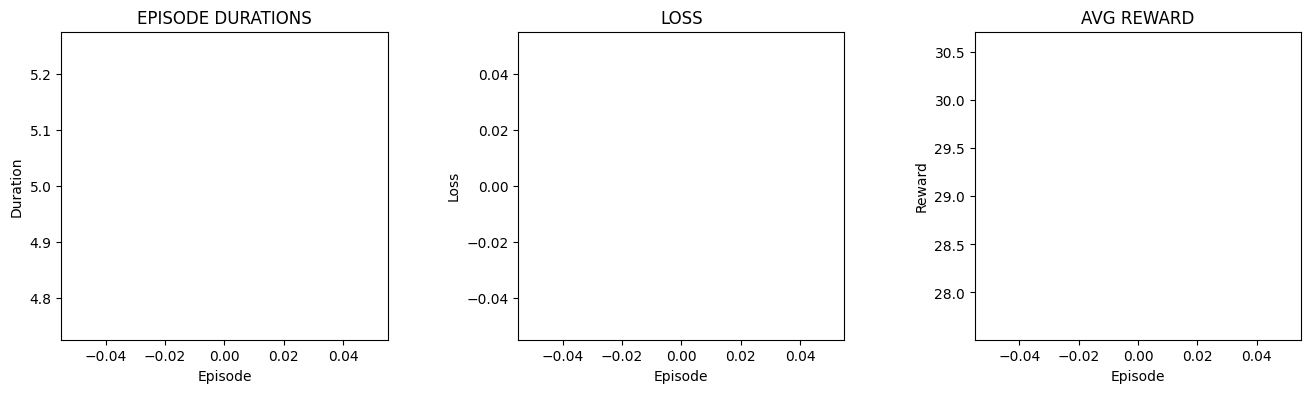

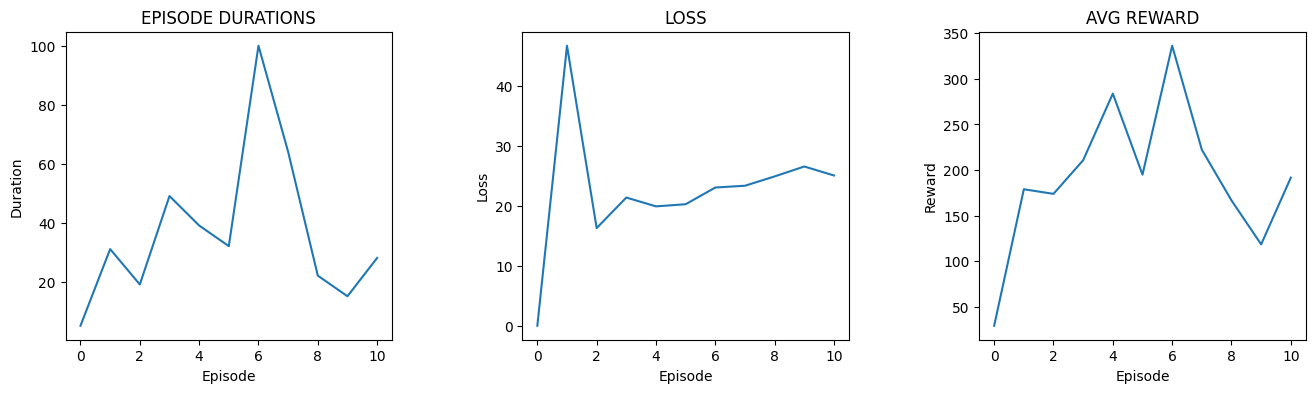

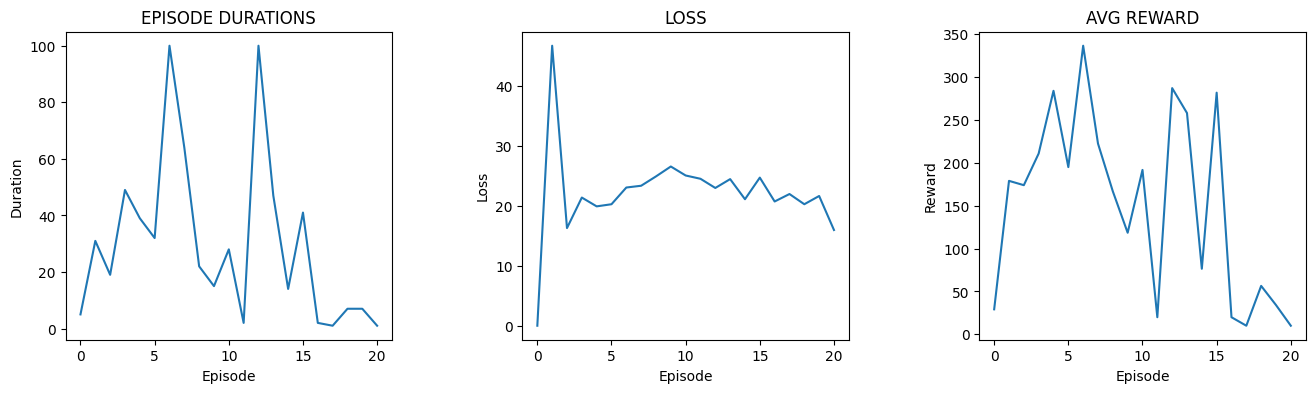

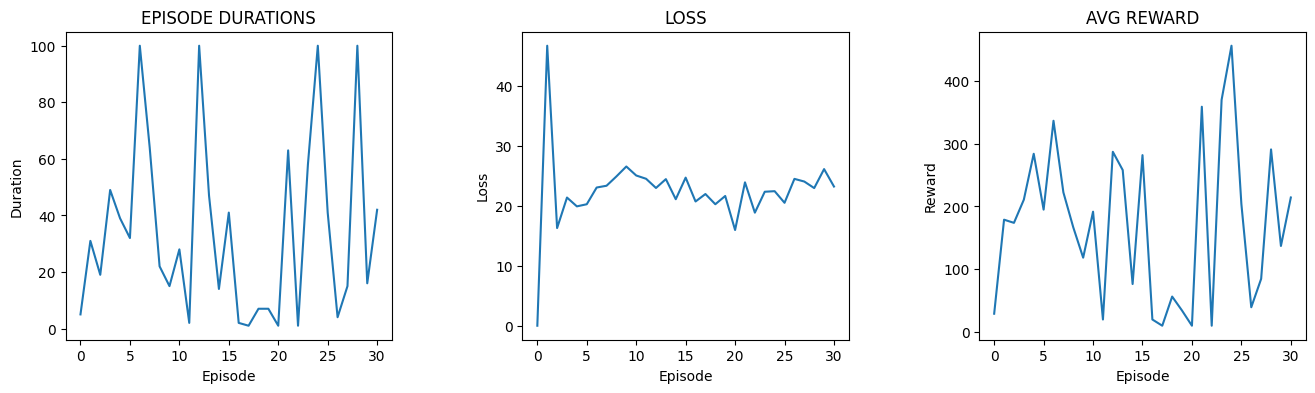

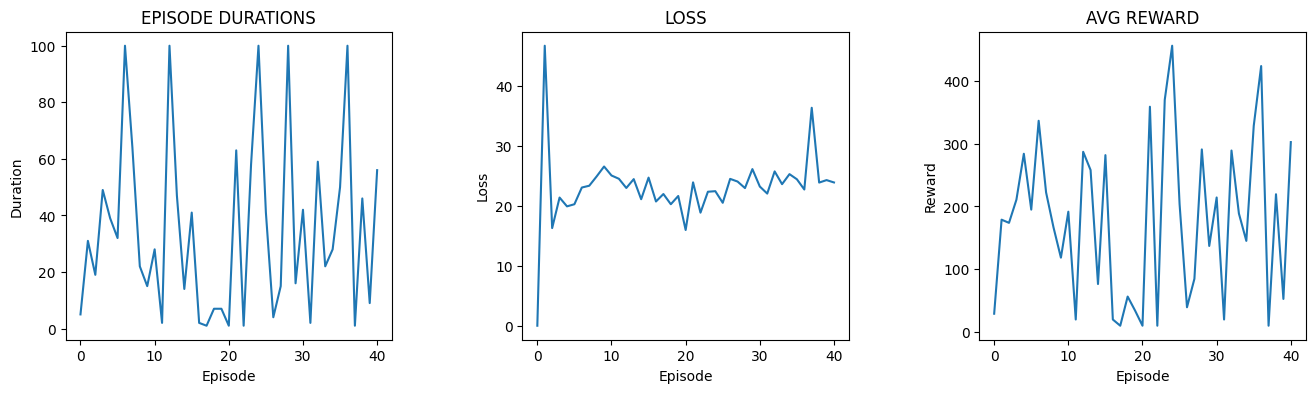

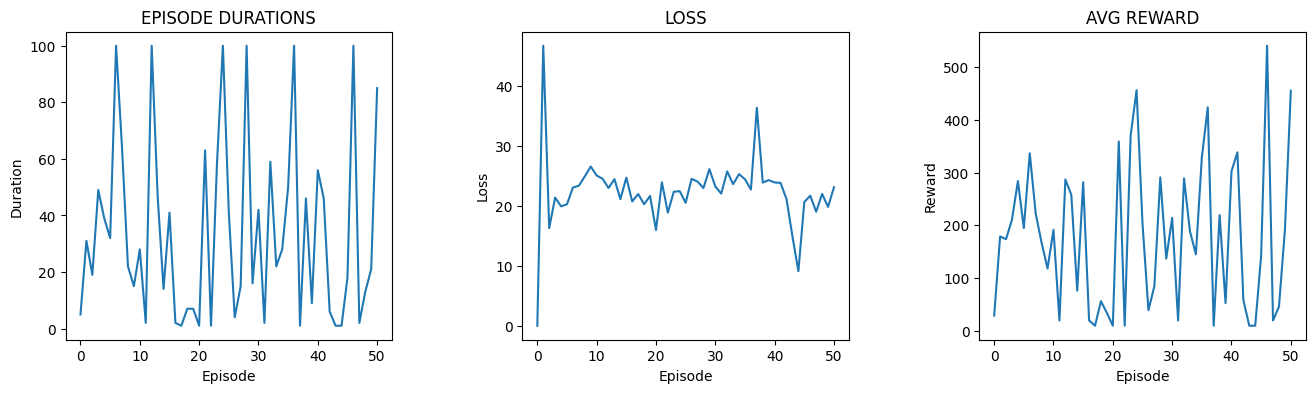

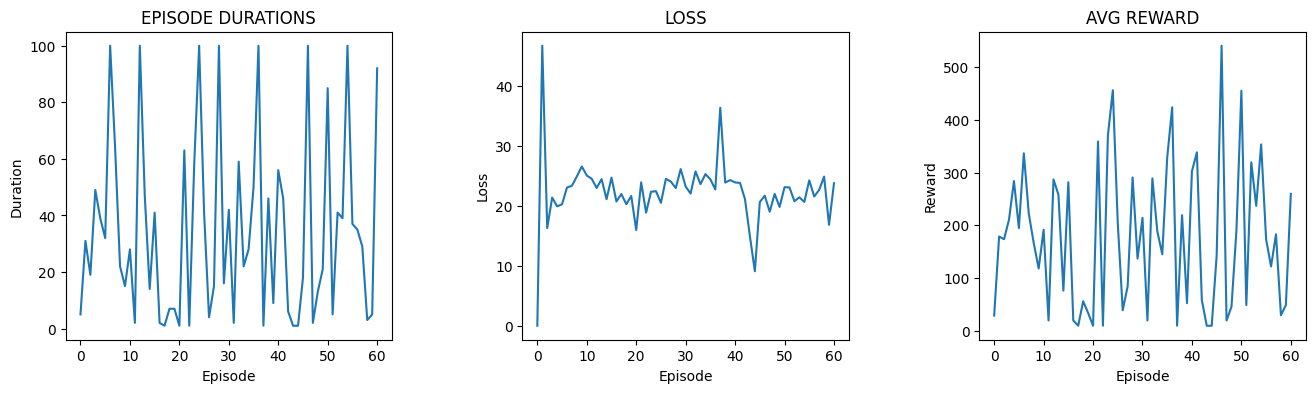

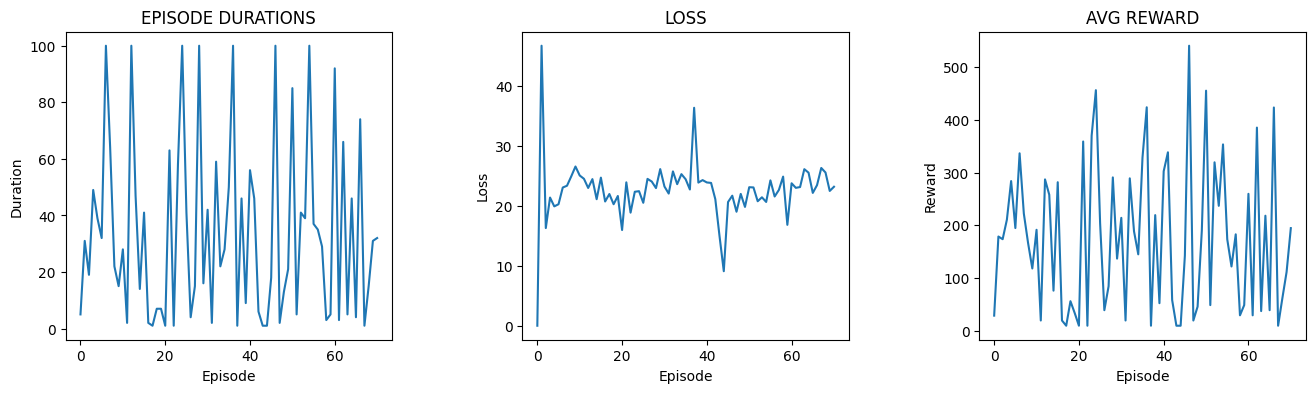

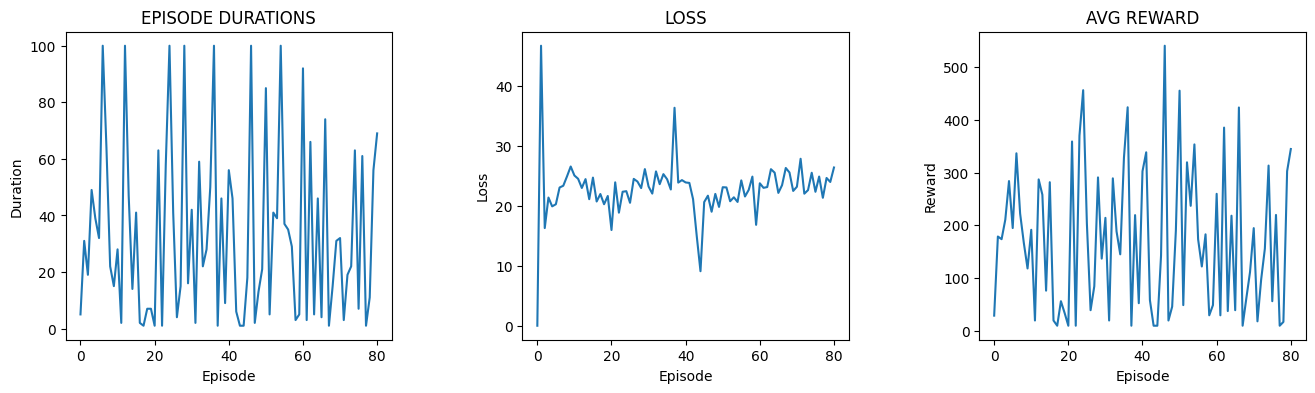

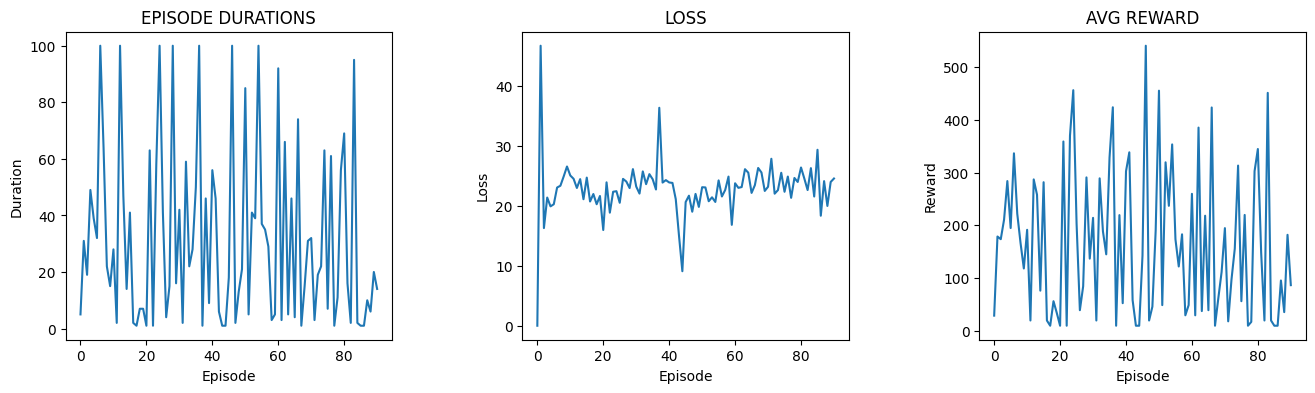

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# custom packages
# from world import PredatorPreyEnv
# from agent import RL_CNN, RandomAgent, DDPGAgent
# from helper import ReplayMemory, Transition

# for interactive plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# parameters for the environment
TAU = 0.001
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
ACTOR_LR = 1e-4
CRITIC_LR = 1e-2
GAMMA = 0.99
NUM_EPISODES = 5000
NUM_PRED = 5
NUM_PREY = 1
BATCH_SIZE = 4
VISION = 7
SIZE = 10
LOAD = False
HISTORY = 4
COMMUNICATION_BIT = 10
env = PredatorPreyEnv(
    render_mode='none',
    size=SIZE,
    predator=NUM_PRED,
    prey=NUM_PREY,
    episode_length=100,
    img_mode=True,
    vision=VISION,
    history_length=HISTORY,
    communication_bits=COMMUNICATION_BIT,
    success_reward=10,
    living_reward=-1.5,
    error_reward=-5,
    cooperate=1
)
state, _ = env.reset()
n_actions = env.single_action_space.n
n_observations = 4 # considering single agent observation space
episode_durations = []
steps_done = 0

losses = []
steps = []
rewards = []

predators = [DDPGAgent((HISTORY*4,VISION,VISION), 
                       n_actions, 
                       num_agents=NUM_PRED, 
                       idd=i,
                       gamma=GAMMA,
                       tau=TAU,
                       actor_lr=ACTOR_LR,
                       critic_lr=CRITIC_LR,
                       communication_bits=COMMUNICATION_BIT,
                       batch_size=BATCH_SIZE
                       ) for i in range(NUM_PRED)]

# prey is random agent
preys = [RandomAgent(VISION*VISION*3, 
                     n_actions,
                     fix_pos=False) for i in range(NUM_PREY)]
fin_losses = []
episode_durations = []
epsilon_predator = EPS_START
epsilon_prey = EPS_START
fin_rewards = []
#load model
if LOAD:
    for i in range(NUM_PRED):
        predators[i].load_model(f"./models2/actor_model_{i}.dict", f"./models2/critic_model{i}.dict")
        predators[i].load_optim(f"./models2/actor_optimizer_{i}.dict", f"./models2/critic_optimizer_{i}.dict")
      
for i_episode in range(NUM_EPISODES):
    # Initialize the environment and get it's state
    state, info = env.reset()
    # print(state)
    losses = []
    episode_reward = 0
    for i_step in count():
        # Select and perform an action
        predator_actions = []
        prey_actions = []
        pred_communication = [0 for _ in range(NUM_PRED)]
        prey_communication = [0 for _ in range(NUM_PREY)]
        if state is None:
            pred_actions = [0 for _ in range(NUM_PRED)]
            prey_actions = [0 for _ in range(NUM_PREY)]
            next_state, reward, done, info = env.step(pred_actions, 
                                                      prey_actions, 
                                                      pred_communication=pred_communication, 
                                                      prey_communication=prey_communication)
            steps_done+=1
            # Move to the next state
            state = next_state
            # if done or i == env.episode_length-1:
            if done:
                episode_durations.append(i_step + 1)
                break
            continue

        #CHOOSE ACTION
        for i in range(NUM_PRED):
            state_i = [torch.tensor(s["predator"][i], dtype=torch.float32, device=device) for s in state]
            state_i = torch.cat(state_i, dim=0).unsqueeze(0)  # 12, 5, 5
            # print(state_i.shape, "AFTER")
            # state_i = torch.tensor(state_i, dtype=torch.float32, device=device).unsqueeze(0)
            action_i, action_choice, msg_i = predators[i].select_action(state_i, epsilon_predator)
            predator_actions.append(action_choice)
            pred_communication[i] = msg_i
            # print(state_i[:4, :, :], "STATE")
            # exit()
            # print(msg_i, "RECIEVED_MSG")
        for i in range(NUM_PREY):
            state_i = [torch.tensor(s["prey"][i], dtype=torch.float32, device=device) for s in state]
            action_i, _= preys[i].select_action(state_i, epsilon_prey)
            prey_actions.append(action_i)
        
        # print(pred_communication, "pred_communication")
        #TAKE ACTION IN ENVIRONMENT
        next_state, reward, done, info = env.step(predator_actions, 
                                                  prey_actions, 
                                                  pred_communication=pred_communication)
        episode_reward += sum(reward["predator"])/len(reward["predator"])*GAMMA**i_step
        # Store the transition in memory
        total_state = []
        total_next_state = []
        reward_total = torch.tensor(reward["predator"], dtype=torch.float32, device=device)
        action_total = torch.tensor(predator_actions, dtype=torch.float32, device=device)
        pred_msg_total = torch.tensor(pred_communication, dtype=torch.float32, device=device)
        done_total = torch.tensor(done, dtype=torch.float32, device=device)

        for i in range(NUM_PRED):
            state_i = [torch.tensor(s["predator"][i], dtype=torch.float32, device=device) for s in state]
            state_i = torch.cat(state_i, dim=0)
            
            next_state_i = [torch.tensor(s["predator"][i], dtype=torch.float32, device=device) for s in next_state]
            next_state_i = torch.cat(next_state_i, dim=0)
            total_state.append(state_i)
            total_next_state.append(next_state_i)
        total_state = torch.cat(total_state, dim=0)
        total_next_state = torch.cat(total_next_state, dim=0)

        for i in range(NUM_PRED):
            predators[i].replay_buffer.push(total_state, action_total, pred_msg_total, reward_total, total_next_state, done_total)
        
        

        # update the Actor-Critic Network
        for i in range(NUM_PRED):
            loss = predators[i].update_model()
            if loss is not None:
                losses.append(loss)
            predators[i].update_target_model()
        for i in range(NUM_PREY):
            preys[i].update_model()
            preys[i].update_target_model()
        
        #decay epsilon
        epsilon_predator = EPS_END + (EPS_START - EPS_END) * \
            np.exp(-1. * steps_done / EPS_DECAY)
        epsilon_prey = EPS_END + (EPS_START - EPS_END) * \
            np.exp(-1. * steps_done / EPS_DECAY)
        steps_done+=1

        # Move to the next state
        state = next_state
#         print('happer')
        if done:
            episode_durations.append(i_step + 1)
            break
    LOSS = sum(losses)/(len(losses)+1)
    fin_losses.append(LOSS)
    fin_rewards.append(episode_reward)
    print(f"Episode {i_episode} finished after {i_step+1} steps with Loss {LOSS:.3f}, REWARD {episode_reward:.3f}", end='\r')
    
    # save model in models folder
    if (i_episode) % 10 == 0:
        for i in range(NUM_PRED):
            torch.save(predators[i].actor_model.state_dict(), f"./models2/actor_model_{i}.dict")
            torch.save(predators[i].critic_model.state_dict(), f"./models2/critic_model{i}.dict")
            torch.save(predators[i].actor_optimizer.state_dict(), f"./models2/actor_optimizer_{i}.dict")
            torch.save(predators[i].critic_optimizer.state_dict(), f"./models2/critic_optimizer_{i}.dict")
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        ax[0].plot(episode_durations)
        ax[0].set_xlabel('Episode')
        ax[0].set_ylabel('Duration')
        ax[0].set_title('EPISODE DURATIONS')
        ax[1].plot(fin_losses)
        ax[1].set_xlabel('Episode')
        ax[1].set_ylabel('Loss')
        ax[1].set_title('LOSS')
        ax[2].plot(fin_rewards)
        ax[2].set_xlabel('Episode')
        ax[2].set_ylabel('Reward')
        ax[2].set_title('AVG REWARD')
        fig.subplots_adjust(wspace=0.4)
        plt.savefig('figure.png', dpi=400)
        plt.show()
# a = input("press any key to continue")